In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.metrics import mean_absolute_error, r2_score, pairwise

pd.set_option("display.max_rows", 100, "display.max_columns", 100)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def p(s):
    print(s)
    
pd.DataFrame.len = pd.Index.len = lambda x: print(len(x))

In [2]:
# Partition training, dev, and test data
seasonHist = pd.read_csv('seasonHist.csv')
X = seasonHist \
    .loc[:,seasonHist.columns.str.contains('-\d+') | seasonHist.columns.str.match('fanPts')] \
    .drop('fanPts',axis=1) \
    .fillna(0)
y = seasonHist.fanPts

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

# Manually downselect useful columns
keepCols = \
    X.columns.str.contains('fanPts') | \
    X.columns.str.contains('^complete_pass') | \
    X.columns.str.contains('rush_attempt') | \
    X.columns.str.contains('yards_gained') | \
    X.columns.str.contains('^touchdown')

X_train_select, X_test_select, y_train_select, y_test_select = train_test_split(X.loc[:,keepCols], y, test_size=0.3, random_state=0)
X_dev_select, X_test_select, y_dev_select, y_test_select = train_test_split(X_test_select, y_test_select, test_size=0.5, random_state=0)

### Decision Tree Regression

#### Base model

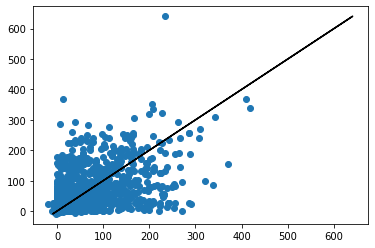

MAE: 39.9
R^2: 0.09


In [3]:
m = tree.DecisionTreeRegressor()
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_pred,y_pred,color='black')
plt.show()

print(f'MAE: {mean_absolute_error(y_dev, y_pred).round(1)}')
print(f'R^2: {r2_score(y_dev, y_pred).round(2)}')

#### GridSearchCV

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  80 out of  95 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    1.6s finished


{'max_features': 45, 'random_state': 0}


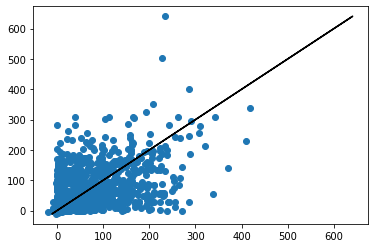

MAE: 40.0
R^2: 0.08


In [22]:
grid = GridSearchCV(
    tree.DecisionTreeRegressor(),
    {
        'max_features':[x for x in range(10,101,5)],
        'random_state':[0]
    },
    n_jobs=-1,
    verbose=7,
    cv=5
).fit(X_train,y_train)

print(grid.best_params_)

m = tree.DecisionTreeRegressor(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_pred,y_pred,color='black')
plt.show()

print(f'MAE: {mean_absolute_error(y_dev, y_pred).round(1)}')
print(f'R^2: {r2_score(y_dev, y_pred).round(2)}')

#### GridSearchCV, hand-selected features

Fitting 5 folds for each of 91 candidates, totalling 455 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 455 out of 455 | elapsed:    3.7s finished


{'max_features': 10, 'random_state': 0}


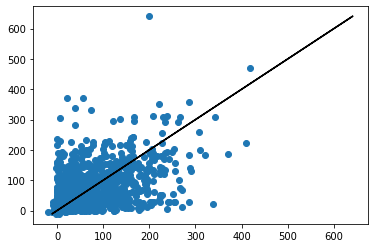

MAE: 38.9
R^2: 0.11


In [25]:
grid = GridSearchCV(
    tree.DecisionTreeRegressor(),
    {
        'max_features':[x for x in range(10,101,1)],
        'random_state':[0]
    },
    n_jobs=-1,
    verbose=7,
    cv=5
).fit(X_train_select,y_train_select)

print(grid.best_params_)

m = tree.DecisionTreeRegressor(**grid.best_params_)
m.fit(X_train_select,y_train_select)
y_pred = m.predict(X_dev_select)

plt.scatter(y_dev_select, y_pred)
plt.plot(y_pred,y_pred,color='black')
plt.show()

print(f'MAE: {mean_absolute_error(y_dev_select, y_pred).round(1)}')
print(f'R^2: {m.score(X_dev_select, y_dev_select).round(2)}')